In [18]:
!pip -q install sentencepiece tqdm matplotlib

'pip' is not recognized as an internal or external command,
operable program or batch file.


Task 1. Get Language Pair

In [19]:
from pathlib import Path
import re, random
from math import floor

In [20]:
from pathlib import Path

en_path = Path(r"D:\NLP\A3_AIT\dataset\TED2020.en-my.en")
my_path = Path(r"D:\NLP\A3_AIT\dataset\TED2020.en-my.my")

assert en_path.exists(), en_path
assert my_path.exists(), my_path

en_lines = en_path.read_text(encoding="utf-8").splitlines()
my_lines = my_path.read_text(encoding="utf-8").splitlines()

print("EN lines:", len(en_lines))
print("MY lines:", len(my_lines))
assert len(en_lines) == len(my_lines), "Parallel files must have same number of lines"


EN lines: 63427
MY lines: 63427


Basic cleaning + normalization

In [21]:
def clean_text(s: str) -> str:
    s = s.strip()
    s = re.sub(r"\s+", " ", s)   # normalize whitespace
    return s

pairs = []
for en, my in zip(en_lines, my_lines):
    en = clean_text(en)
    my = clean_text(my)
    if en and my:
        pairs.append((en, my))

print("Pairs after cleaning:", len(pairs))
print("Sample EN:", pairs[0][0][:120])
print("Sample MY:", pairs[0][1][:120])


Pairs after cleaning: 62492
Sample EN: With all the legitimate concerns about AIDS and avian flu -- and we'll hear about that from the brilliant Dr. Brilliant 
Sample MY: AIDS နဲ့ ကြက်ငှက်တုပ်ကွေးတို့နဲ့ ပတ်သက်ပြီး တရားဝင်ပူပန်မှုတွေ၊ နဲ့ ဒီနေ့နှောင်းပိုင်းမှာ အရမ်းတော်တဲ့ Dr. Brillant ဆီကက


In [22]:
random.seed(42)

MAX_PAIRS =10000
MAX_LEN_CHARS = 300 

random.shuffle(pairs)
pairs = pairs[:MAX_PAIRS]
pairs = [(en, my) for en, my in pairs if len(en) <= MAX_LEN_CHARS and len(my) <= MAX_LEN_CHARS]

print("Pairs after subsample+filter:", len(pairs))


Pairs after subsample+filter: 9812


I purpusly reduce the corpus to reduce the training process.

Train/Valid/Test split

In [23]:
n = len(pairs)
n_train = floor(n * 0.90)
n_valid = floor(n * 0.05)
n_test  = n - n_train - n_valid

train_pairs = pairs[:n_train]
valid_pairs = pairs[n_train:n_train+n_valid]
test_pairs  = pairs[n_train+n_valid:]

print("Train/Valid/Test:", len(train_pairs), len(valid_pairs), len(test_pairs))


Train/Valid/Test: 8830 490 492


Write plain-text training files (for tokenizer training)

In [24]:
workdir = Path("./work_mt")
workdir.mkdir(exist_ok=True)

train_en_txt = workdir/"train.en"
train_my_txt = workdir/"train.my"

train_en_txt.write_text("\n".join([en for en, _ in train_pairs]), encoding="utf-8")
train_my_txt.write_text("\n".join([my for _, my in train_pairs]), encoding="utf-8")

print("Wrote:", train_en_txt, train_my_txt)


Wrote: work_mt\train.en work_mt\train.my


Train SentencePiece (segmentation/tokenization)

In [25]:
import sentencepiece as spm

VOCAB_SIZE_EN = 8000
VOCAB_SIZE_MY = 8000

spm.SentencePieceTrainer.Train(
    input=str(train_en_txt),
    model_prefix=str(workdir/"spm_en"),
    vocab_size=VOCAB_SIZE_EN,
    model_type="unigram",
    character_coverage=1.0
)

spm.SentencePieceTrainer.Train(
    input=str(train_my_txt),
    model_prefix=str(workdir/"spm_my"),
    vocab_size=VOCAB_SIZE_MY,
    model_type="unigram",
    character_coverage=1.0
)

print("Saved tokenizers to:", workdir)


Saved tokenizers to: work_mt


Load tokenizers + sanity check segmentation

In [26]:
sp_en = spm.SentencePieceProcessor(model_file=str(workdir/"spm_en.model"))
sp_my = spm.SentencePieceProcessor(model_file=str(workdir/"spm_my.model"))

ex_en, ex_my = train_pairs[0]
print("EN:", ex_en)
print("EN pieces:", sp_en.encode(ex_en, out_type=str)[:25])

print("\nMY:", ex_my)
print("MY pieces:", sp_my.encode(ex_my, out_type=str)[:25])


EN: It's 30, 40, 50, 100 years.
EN pieces: ['▁It', "'", 's', '▁30', ',', '▁40', ',', '▁50', ',', '▁100', '▁years', '.']

MY: နှစ်ပေါင်း ၃၀၊ ၄၀၊ ၅၀၊ ၁၀၀ စသဖြင့် ဖြစ်ရမယ်။
MY pieces: ['▁နှစ်ပေါင်း', '▁၃၀', '၊', '▁၄၀', '၊', '▁၅၀', '၊', '▁၁၀၀', '▁စသဖြင့်', '▁ဖြစ်', 'ရမယ်။']


Export splits

In [27]:
def write_pairs(pairs, out_en, out_my):
    out_en.write_text("\n".join([en for en, _ in pairs]), encoding="utf-8")
    out_my.write_text("\n".join([my for _, my in pairs]), encoding="utf-8")

write_pairs(train_pairs, workdir/"split_train.en", workdir/"split_train.my")
write_pairs(valid_pairs, workdir/"split_valid.en", workdir/"split_valid.my")
write_pairs(test_pairs,  workdir/"split_test.en",  workdir/"split_test.my")

print("Splits saved in", workdir.resolve())


Splits saved in D:\NLP\A3_AIT\work_mt


I saved this, so I can use in Task 2

Task 2

Setup SentencePiece tokenizers (PAD token)

In [28]:
import sentencepiece as spm
from pathlib import Path

workdir = Path("./work_mt")
workdir.mkdir(exist_ok=True)

train_en_txt = workdir/"train.en"
train_my_txt = workdir/"train.my"

# these should exist from Task 1; if not, rerun Task 1 cell that writes them
assert train_en_txt.exists(), train_en_txt
assert train_my_txt.exists(), train_my_txt

# Use a vocab size <= the number of unique pieces available in the corpus.
VOCAB_SIZE_EN = 11000
VOCAB_SIZE_MY = 11000

spm.SentencePieceTrainer.Train(
    input=str(train_en_txt),
    model_prefix=str(workdir/"spm_en"),
    vocab_size=VOCAB_SIZE_EN,
    model_type="unigram",
    character_coverage=1.0,
    pad_id=3, unk_id=0, bos_id=1, eos_id=2
)

spm.SentencePieceTrainer.Train(
    input=str(train_my_txt),
    model_prefix=str(workdir/"spm_my"),
    vocab_size=VOCAB_SIZE_MY,
    model_type="unigram",
    character_coverage=1.0,
    pad_id=3, unk_id=0, bos_id=1, eos_id=2
)

print("Tokenizers ready with PAD/BOS/EOS/UNK ids.")


Tokenizers ready with PAD/BOS/EOS/UNK ids.


Load tokenizers + define special IDs

In [29]:
import sentencepiece as spm

sp_en = spm.SentencePieceProcessor(model_file=str(workdir/"spm_en.model"))
sp_my = spm.SentencePieceProcessor(model_file=str(workdir/"spm_my.model"))

PAD_EN, BOS_EN, EOS_EN, UNK_EN = sp_en.pad_id(), sp_en.bos_id(), sp_en.eos_id(), sp_en.unk_id()
PAD_MY, BOS_MY, EOS_MY, UNK_MY = sp_my.pad_id(), sp_my.bos_id(), sp_my.eos_id(), sp_my.unk_id()

print("EN ids:", {"pad":PAD_EN,"bos":BOS_EN,"eos":EOS_EN,"unk":UNK_EN})
print("MY ids:", {"pad":PAD_MY,"bos":BOS_MY,"eos":EOS_MY,"unk":UNK_MY})
print("Vocab sizes:", sp_en.get_piece_size(), sp_my.get_piece_size())


EN ids: {'pad': 3, 'bos': 1, 'eos': 2, 'unk': 0}
MY ids: {'pad': 3, 'bos': 1, 'eos': 2, 'unk': 0}
Vocab sizes: 11000 11000


Dataset and DataLoader

In [30]:
import torch
from torch.utils.data import Dataset, DataLoader

class ParallelTextDataset(Dataset):
    def __init__(self, en_file, my_file, sp_src, sp_tgt):
        self.src = Path(en_file).read_text(encoding="utf-8").splitlines()
        self.tgt = Path(my_file).read_text(encoding="utf-8").splitlines()
        assert len(self.src) == len(self.tgt)
        self.sp_src = sp_src
        self.sp_tgt = sp_tgt

    def __len__(self):
        return len(self.src)

    def __getitem__(self, idx):
        src_ids = self.sp_src.encode(self.src[idx], out_type=int)
        tgt_ids = self.sp_tgt.encode(self.tgt[idx], out_type=int)
        # add BOS/EOS
        src_ids = [self.sp_src.bos_id()] + src_ids + [self.sp_src.eos_id()]
        tgt_ids = [self.sp_tgt.bos_id()] + tgt_ids + [self.sp_tgt.eos_id()]
        return torch.tensor(src_ids, dtype=torch.long), torch.tensor(tgt_ids, dtype=torch.long)

def collate_batch(batch, pad_src, pad_tgt):
    src_batch, tgt_batch = zip(*batch)
    src_lens = torch.tensor([len(x) for x in src_batch], dtype=torch.long)

    src_batch = torch.nn.utils.rnn.pad_sequence(src_batch, padding_value=pad_src)  # [src_len, batch]
    tgt_batch = torch.nn.utils.rnn.pad_sequence(tgt_batch, padding_value=pad_tgt)  # [tgt_len, batch]
    return src_batch, src_lens, tgt_batch

BATCH_SIZE = 32

train_ds = ParallelTextDataset(workdir/"split_train.en", workdir/"split_train.my", sp_en, sp_my)
valid_ds = ParallelTextDataset(workdir/"split_valid.en", workdir/"split_valid.my", sp_en, sp_my)
test_ds  = ParallelTextDataset(workdir/"split_test.en",  workdir/"split_test.my",  sp_en, sp_my)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          collate_fn=lambda b: collate_batch(b, PAD_EN, PAD_MY))
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=lambda b: collate_batch(b, PAD_EN, PAD_MY))
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False,
                          collate_fn=lambda b: collate_batch(b, PAD_EN, PAD_MY))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)


device: cpu


Attention mechanisms


In [31]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, dropout):
        super().__init__()
        self.embedding = nn.Embedding(input_dim, emb_dim, padding_idx=PAD_EN)
        self.rnn = nn.GRU(emb_dim, hid_dim, bidirectional=True)
        self.fc = nn.Linear(hid_dim * 2, hid_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_len):
        # src: [src_len, batch]
        embedded = self.dropout(self.embedding(src))  # [src_len, batch, emb_dim]

        packed = nn.utils.rnn.pack_padded_sequence(embedded, src_len.cpu(), enforce_sorted=False)
        packed_outputs, hidden = self.rnn(packed)
        encoder_outputs, _ = nn.utils.rnn.pad_packed_sequence(packed_outputs)
        # encoder_outputs: [src_len, batch, hid_dim*2]

        # hidden from BiGRU: [2, batch, hid_dim] => combine directions
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        # hidden: [batch, hid_dim]
        return encoder_outputs, hidden


class GeneralAttention(nn.Module):
    """
    General Attention (Luong-style) with projection to match dimensions.
    Equation required by assignment:
      e_i = s^T h_i  (d1 = d2)
    Here, encoder outputs are hid_dim*2 (biGRU), so we project:
      h'_i = W h_i  -> hid_dim
      e_i = s^T h'_i
    """
    def __init__(self, hid_dim):
        super().__init__()
        self.proj = nn.Linear(hid_dim * 2, hid_dim, bias=False)

    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch, hid_dim]
        # encoder_outputs: [src_len, batch, hid_dim*2]
        src_len = encoder_outputs.shape[0]

        enc = encoder_outputs.permute(1,0,2)          # [batch, src_len, hid_dim*2]
        enc = self.proj(enc)                           # [batch, src_len, hid_dim]
        hid = hidden.unsqueeze(2)                      # [batch, hid_dim, 1]
        energy = torch.bmm(enc, hid).squeeze(2)        # [batch, src_len]

        energy = energy.masked_fill(mask, -1e10)
        return F.softmax(energy, dim=1)


class AdditiveAttention(nn.Module):
    """
    Additive Attention (Bahdanau-style) required by assignment:
      e_i = v^T tanh(W1 h_i + W2 s)
    Matches professor notebook structure.
    """
    def __init__(self, hid_dim):
        super().__init__()
        self.v = nn.Linear(hid_dim, 1, bias=False)
        self.W = nn.Linear(hid_dim, hid_dim)          # for decoder hidden s
        self.U = nn.Linear(hid_dim * 2, hid_dim)      # for encoder outputs h_i

    def forward(self, hidden, encoder_outputs, mask):
        # hidden: [batch, hid_dim]
        # encoder_outputs: [src_len, batch, hid_dim*2]
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]

        hidden_rep = hidden.unsqueeze(1).repeat(1, src_len, 1)  # [batch, src_len, hid_dim]
        enc = encoder_outputs.permute(1,0,2)                    # [batch, src_len, hid_dim*2]

        energy = self.v(torch.tanh(self.W(hidden_rep) + self.U(enc))).squeeze(2)  # [batch, src_len]
        energy = energy.masked_fill(mask, -1e10)
        return F.softmax(energy, dim=1)


class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, dropout, attention):
        super().__init__()
        self.output_dim = output_dim
        self.attention = attention
        self.embedding = nn.Embedding(output_dim, emb_dim, padding_idx=PAD_MY)
        self.rnn = nn.GRU(hid_dim * 2 + emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim * 3 + emb_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input_tok, hidden, encoder_outputs, mask):
        # input_tok: [batch]
        input_tok = input_tok.unsqueeze(0)  # [1, batch]
        embedded = self.dropout(self.embedding(input_tok))  # [1, batch, emb_dim]

        attn = self.attention(hidden, encoder_outputs, mask)          # [batch, src_len]
        attn = attn.unsqueeze(1)                                      # [batch, 1, src_len]

        enc = encoder_outputs.permute(1,0,2)                          # [batch, src_len, hid_dim*2]
        weighted = torch.bmm(attn, enc)                               # [batch, 1, hid_dim*2]
        weighted = weighted.permute(1,0,2)                            # [1, batch, hid_dim*2]

        rnn_input = torch.cat((embedded, weighted), dim=2)            # [1, batch, emb_dim + hid_dim*2]
        output, hidden_new = self.rnn(rnn_input, hidden.unsqueeze(0)) # output: [1,batch,hid_dim]
        output = output.squeeze(0)
        hidden_new = hidden_new.squeeze(0)
        embedded = embedded.squeeze(0)
        weighted = weighted.squeeze(0)

        pred = self.fc_out(torch.cat((output, weighted, embedded), dim=1))  # [batch, output_dim]
        return pred, hidden_new, attn.squeeze(1)


class Seq2SeqPackedAttention(nn.Module):
    def __init__(self, encoder, decoder, src_pad_idx, device):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.device = device

    def create_mask(self, src):
        # src: [src_len, batch]
        return (src == self.src_pad_idx).permute(1,0)  # [batch, src_len]

    def forward(self, src, src_len, trg, teacher_forcing_ratio=0.5):
        # trg: [trg_len, batch]
        trg_len, batch_size = trg.shape
        out_dim = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, out_dim, device=self.device)
        encoder_outputs, hidden = self.encoder(src, src_len)
        mask = self.create_mask(src)

        input_tok = trg[0,:]  # BOS
        for t in range(1, trg_len):
            pred, hidden, _ = self.decoder(input_tok, hidden, encoder_outputs, mask)
            outputs[t] = pred
            teacher_force = torch.rand(1).item() < teacher_forcing_ratio
            top1 = pred.argmax(1)
            input_tok = trg[t] if teacher_force else top1
        return outputs


Training + evaluation (loss + perplexity)

In [32]:
import math, time
import torch.optim as optim

def train_epoch(model, loader, optimizer, criterion, clip=1.0):
    model.train()
    epoch_loss = 0
    for src, src_len, trg in loader:
        src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)

        optimizer.zero_grad()
        output = model(src, src_len, trg, teacher_forcing_ratio=0.5)
        # output: [trg_len, batch, vocab]
        output_dim = output.shape[-1]

        output = output[1:].reshape(-1, output_dim)
        trg_gold = trg[1:].reshape(-1)

        loss = criterion(output, trg_gold)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()

    return epoch_loss / len(loader)

@torch.no_grad()
def eval_epoch(model, loader, criterion):
    model.eval()
    epoch_loss = 0
    for src, src_len, trg in loader:
        src, src_len, trg = src.to(device), src_len.to(device), trg.to(device)
        output = model(src, src_len, trg, teacher_forcing_ratio=0.0)
        output_dim = output.shape[-1]

        output = output[1:].reshape(-1, output_dim)
        trg_gold = trg[1:].reshape(-1)

        loss = criterion(output, trg_gold)
        epoch_loss += loss.item()

    return epoch_loss / len(loader)


In [33]:
def run_experiment(attn_type="general", N_EPOCHS=4, emb_dim=128, hid_dim=128, dropout=0.3, lr=1e-3):
    input_dim = sp_en.get_piece_size()
    output_dim = sp_my.get_piece_size()

    if attn_type == "general":
        attention = GeneralAttention(hid_dim)
    elif attn_type == "additive":
        attention = AdditiveAttention(hid_dim)
    else:
        raise ValueError("attn_type must be 'general' or 'additive'")

    enc = Encoder(input_dim, emb_dim, hid_dim, dropout)
    dec = Decoder(output_dim, emb_dim, hid_dim, dropout, attention)
    model = Seq2SeqPackedAttention(enc, dec, src_pad_idx=PAD_EN, device=device).to(device)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_MY)

    history = {"train_loss": [], "valid_loss": [], "train_ppl": [], "valid_ppl": []}

    for epoch in range(1, N_EPOCHS+1):
        start = time.time()
        tr_loss = train_epoch(model, train_loader, optimizer, criterion)
        va_loss = eval_epoch(model, valid_loader, criterion)

        tr_ppl = math.exp(tr_loss)
        va_ppl = math.exp(va_loss)

        history["train_loss"].append(tr_loss)
        history["valid_loss"].append(va_loss)
        history["train_ppl"].append(tr_ppl)
        history["valid_ppl"].append(va_ppl)

        print(f"[{attn_type.upper()}] Epoch {epoch}/{N_EPOCHS} | "
              f"train_loss={tr_loss:.3f} train_ppl={tr_ppl:.2f} | "
              f"valid_loss={va_loss:.3f} valid_ppl={va_ppl:.2f} | "
              f"time={(time.time()-start):.1f}s")

    return model, history


In [ ]:
general_model, general_hist = run_experiment("general", N_EPOCHS=5)
additive_model, additive_hist = run_experiment("additive", N_EPOCHS=5)


[GENERAL] Epoch 1/5 | train_loss=7.809 train_ppl=2462.93 | valid_loss=7.401 valid_ppl=1636.86 | time=216.2s
[GENERAL] Epoch 2/5 | train_loss=7.331 train_ppl=1526.37 | valid_loss=7.322 valid_ppl=1513.75 | time=215.4s
[GENERAL] Epoch 3/5 | train_loss=7.045 train_ppl=1146.79 | valid_loss=7.285 valid_ppl=1458.95 | time=216.8s
[GENERAL] Epoch 4/5 | train_loss=6.735 train_ppl=841.59 | valid_loss=7.311 valid_ppl=1497.34 | time=215.7s
[GENERAL] Epoch 5/5 | train_loss=6.426 train_ppl=617.59 | valid_loss=7.372 valid_ppl=1590.81 | time=216.0s
[ADDITIVE] Epoch 1/5 | train_loss=7.788 train_ppl=2410.45 | valid_loss=7.366 valid_ppl=1581.87 | time=230.9s
[ADDITIVE] Epoch 2/5 | train_loss=7.245 train_ppl=1401.38 | valid_loss=7.242 valid_ppl=1396.28 | time=232.1s
[ADDITIVE] Epoch 3/5 | train_loss=6.891 train_ppl=982.94 | valid_loss=7.217 valid_ppl=1362.55 | time=229.0s
[ADDITIVE] Epoch 4/5 | train_loss=6.530 train_ppl=685.55 | valid_loss=7.243 valid_ppl=1398.60 | time=231.9s
[ADDITIVE] Epoch 5/5 | train

Task 3. Evaluation and Verification

| Attention Mechanism | Training Loss | Training PPL | Validation Loss | Validation PPL | Time / Epoch (sec) |
|---------------------|---------------|--------------|------------------|----------------|-------------------|
| General Attention   | 6.426         | 617.59       | 7.372            | 1590.81        | 216.0             |
| Additive Attention  | 6.180         | 482.75       | 7.294            | 1471.79        | 228.9             |


Greedy translate + capture attention weights

In [35]:
import torch
import numpy as np

@torch.no_grad()
def translate_with_attention(model, sentence_en: str, max_len=60):
    model.eval()

    # Encode source
    src_ids = [sp_en.bos_id()] + sp_en.encode(sentence_en, out_type=int) + [sp_en.eos_id()]
    src = torch.tensor(src_ids, dtype=torch.long).unsqueeze(1).to(device)      # [src_len, 1]
    src_len = torch.tensor([len(src_ids)], dtype=torch.long).to(device)

    encoder_outputs, hidden = model.encoder(src, src_len)
    mask = model.create_mask(src)

    # Decode step-by-step
    trg_ids = [sp_my.bos_id()]
    attentions = []

    input_tok = torch.tensor([sp_my.bos_id()], dtype=torch.long).to(device)

    for _ in range(max_len):
        pred, hidden, attn = model.decoder(input_tok, hidden, encoder_outputs, mask)
        # attn: [batch=1, src_len]
        attentions.append(attn.squeeze(0).detach().cpu().numpy())

        top1 = pred.argmax(1).item()
        trg_ids.append(top1)

        if top1 == sp_my.eos_id():
            break

        input_tok = torch.tensor([top1], dtype=torch.long).to(device)

    # Decode pieces to text
    src_pieces = ["<bos>"] + sp_en.encode(sentence_en, out_type=str) + ["<eos>"]
    trg_pieces = [sp_my.id_to_piece(i) for i in trg_ids]

    return src_pieces, trg_pieces, np.stack(attentions, axis=0)


Plot attention heatmap

In [36]:
import matplotlib.pyplot as plt

def plot_attention(src_pieces, tgt_pieces, attn):
    # attn shape: [tgt_len-1, src_len] (we recorded each decode step)
    plt.figure(figsize=(min(12, 0.6*len(src_pieces)), min(10, 0.5*len(tgt_pieces))))
    plt.imshow(attn, aspect="auto")
    plt.xticks(range(len(src_pieces)), src_pieces, rotation=90)
    plt.yticks(range(len(tgt_pieces)-1), tgt_pieces[1:])  # skip bos on y-axis
    plt.xlabel("Source (English)")
    plt.ylabel("Target (Myanmar pieces)")
    plt.title("Attention Map")
    plt.colorbar()
    plt.tight_layout()
    plt.show()


GENERAL output pieces: ['<s>', '▁ကျွန်တော်ဟာ', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', '</s>']


C:\Users\Admin\AppData\Local\Temp\ipykernel_14756\968985976.py:13: UserWarning: Glyph 4096 (\N{MYANMAR LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_14756\968985976.py:13: UserWarning: Glyph 4155 (\N{MYANMAR CONSONANT SIGN MEDIAL YA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_14756\968985976.py:13: UserWarning: Glyph 4157 (\N{MYANMAR CONSONANT SIGN MEDIAL WA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_14756\968985976.py:13: UserWarning: Glyph 4116 (\N{MYANMAR LETTER NA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_14756\968985976.py:13: UserWarning: Glyph 4154 (\N{MYANMAR SIGN ASAT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_14756\968985976.py:13: UserWarning: Glyph 4112 (\N{MYANMAR LETTER TA}) missi

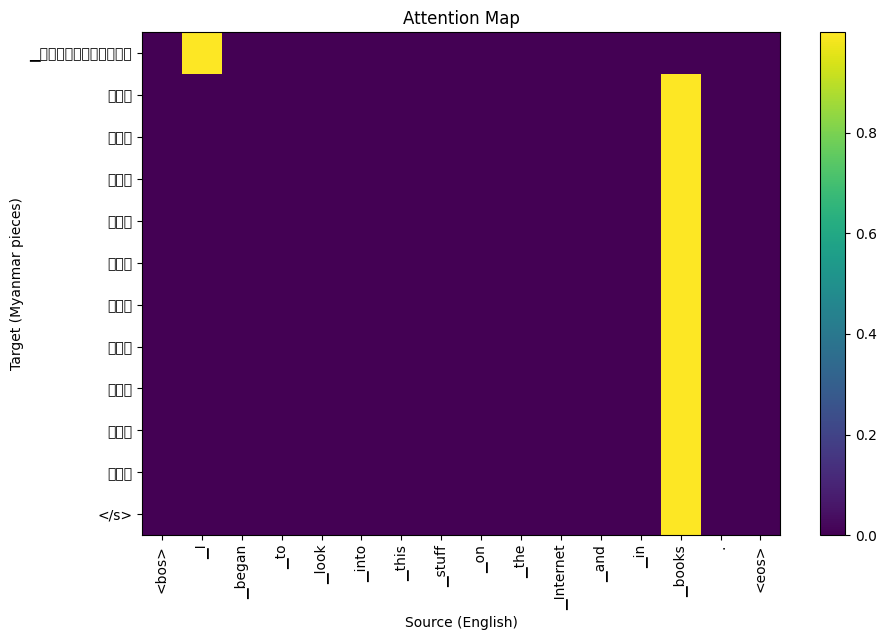

ADDITIVE output pieces: ['<s>', '▁', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', 'ကို', '</s>']


C:\Users\Admin\AppData\Local\Temp\ipykernel_14756\968985976.py:13: UserWarning: Glyph 4096 (\N{MYANMAR LETTER KA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_14756\968985976.py:13: UserWarning: Glyph 4141 (\N{MYANMAR VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_14756\968985976.py:13: UserWarning: Glyph 4143 (\N{MYANMAR VOWEL SIGN U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
d:\NLP\A3_AIT\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4096 (\N{MYANMAR LETTER KA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\NLP\A3_AIT\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4141 (\N{MYANMAR VOWEL SIGN I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\NLP\A3_AIT\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 4143

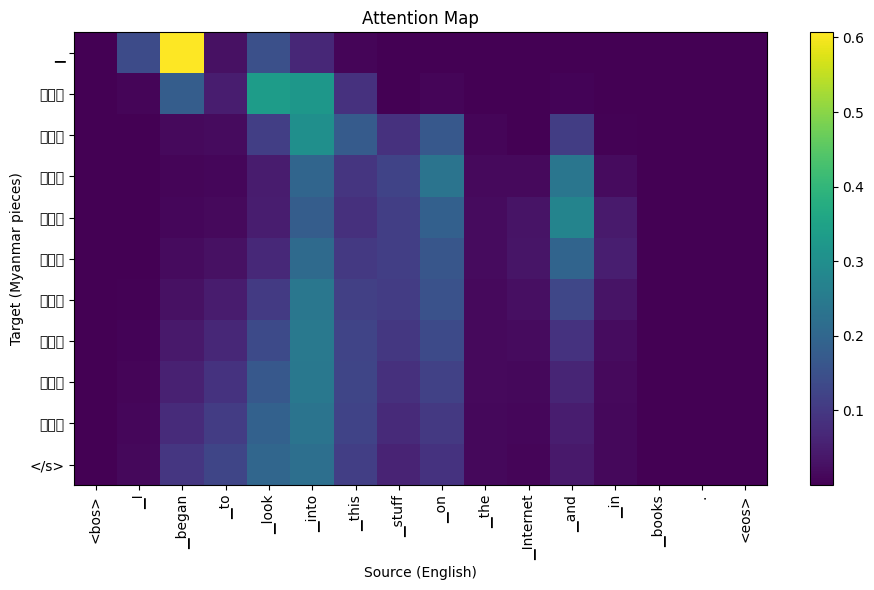

In [40]:
test_sentence = "I began to look into this stuff on the Internet and in books. "

src_p, tgt_p_gen, attn_gen = translate_with_attention(general_model, test_sentence, max_len=50)
print("GENERAL output pieces:", tgt_p_gen[:30])
plot_attention(src_p, tgt_p_gen, attn_gen)

src_p, tgt_p_add, attn_add = translate_with_attention(additive_model, test_sentence, max_len=50)
print("ADDITIVE output pieces:", tgt_p_add[:30])
plot_attention(src_p, tgt_p_add, attn_add)


### Attention Mechanism Comparison

Due to limited training time and computational constraints, both models do not produce fully fluent Myanmar translations and tend to repeat frequent tokens. However, the goal of this experiment is not perfect translation quality, but to compare the behavior of different attention mechanisms.

From the attention maps, General Attention shows very concentrated patterns, where many target tokens focus on the same source position. This indicates that the model relies heavily on a small part of the input sentence, which results in repetitive outputs and weaker alignment across the sequence. Additive Attention, on the other hand, produces more distributed attention weights across multiple source tokens. The attention maps show smoother transitions and a clearer relationship between source and target tokens. This suggests that the decoder is able to consider more contextual information when generating each target token.

Quantitatively, Additive Attention also achieves slightly lower validation loss and perplexity compared to General Attention. Although Additive Attention requires slightly more computation time per epoch, it demonstrates better alignment behavior and overall performance under the same experimental settings. Based on both the numerical results and the attention visualizations, Additive Attention is more suitable for the English–Myanmar translation task in this experiment.



Task 4. Machine Translation

In [41]:
from pathlib import Path
import torch, shutil

app_dir = Path("app")
app_dir.mkdir(exist_ok=True)

# save model
torch.save({
    "model_state": additive_model.state_dict(),
    "emb_dim": 128,
    "hid_dim": 128,
    "vocab_en": sp_en.get_piece_size(),
    "vocab_my": sp_my.get_piece_size()
}, app_dir / "additive_model.pt")

# copy tokenizers
shutil.copy("work_mt/spm_en.model", app_dir / "spm_en.model")
shutil.copy("work_mt/spm_my.model", app_dir / "spm_my.model")

print("✅ Model + tokenizers saved into app/")


✅ Model + tokenizers saved into app/
